# GA 1.4: Modelling Road Deformation using Non-Linear Least-Squares

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.4. Due: Friday, September 27, 2024.*

## Part 0: Recap of GA 1.3

As you (hopefully!) recall, last week we investigated observed displacements of a road in the Green Heart of the Netherlands, where groundwater levels play a significant role. The model was defined as:

$$
d = d_0 + vt + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is time and $\textrm{GW}$ is the groundwater level (that we assume to be deterministic). 

Therefore, the model has 3 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $v$, as the displacement velocity;
3. $k$, as the 'groundwater factor', which can be seen as the response of the soil to changes in the groundwater level.

We used BLUE to create a linear model, which we conveniently stored in a dictionary. Let's start by spending a few minutes refreshing our memory about this model.

In [1]:
import numpy as np
from scipy import interpolate
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
from scipy.stats.distributions import chi2

from functions import *

np.set_printoptions(precision=3);

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.1: </b>   
    
Run the cell below to load two dictionaries (objects) into the Python variable space, <code>m1</code> and <code>m2</code>. You can uncomment and run the code to check the key:value pairs.
    
</p>
</div>

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>

Note that the objects are stored in and loaded from "pickle" files, a native Python serialization format (in non-technical speak: a pickle file saves our variables to use them later, like we do here). The model dictionaries were defined and saved in the file <code>setup.py</code>, which you are welcome to read if you are curious.
</p></div>

In [2]:
m1_blue = load_pickle_file('m1_blue.pickle')
m2_blue = load_pickle_file('m2_blue.pickle')

Sometimes it can be difficult to get a sense of the contents of the dictionary, so we made a simple function to help summarize it:

In [3]:
model_summary(m1_blue)
model_summary(m2_blue)

Summary of Model
----------------
  Data type: InSAR
  Model type: BLUE
  Number of observations: 61
  Model parameters:
    X_hat_0 =    9.174  +/-  2.128  (c.o.v.  0.232)
    X_hat_1 =   -0.024  +/-  0.001  (c.o.v. -0.050)
    X_hat_2 =    0.202  +/-  0.016  (c.o.v.  0.081)
----------------

Summary of Model
----------------
  Data type: GNSS
  Model type: BLUE
  Number of observations: 730
  Model parameters:
    X_hat_0 =    1.181  +/-  4.647  (c.o.v.  3.936)
    X_hat_1 =   -0.021  +/-  0.003  (c.o.v. -0.126)
    X_hat_2 =    0.160  +/-  0.035  (c.o.v.  0.220)
----------------



Remember you can also print the keys using a simple for loop like this:

In [4]:
for key in m1_blue.keys():
    print(key)

data_type
model_type
times
y
days
groundwater
groundwater_data
A
std_Y
Sigma_Y
Sigma_X_hat
X_hat
Y_hat
e_hat
Sigma_Y_hat
Sigma_e_hat
std_e_hat
k
CI_Y
CI_res
CI_Y_hat
alpha


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.2: </b>   
    
Run the cell below to activate the widget. Play with the parameter values until you are completely familiar with what each one does, and confirm that the model results from last week are indeed those that minimize the mean of the squared residuals.
    
</p>
</div>

In [6]:
x0_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.1, description='x0')
x1_slider = widgets.FloatSlider(value=0, min=-0.1, max=0.1, step=0.001, description='x1')
x2_slider = widgets.FloatSlider(value=1, min=-1, max=1, step=0.01, description='x2')

interact(model_widget,
         x0=x0_slider, x1=x1_slider, x2=x2_slider, x3=fixed(None),
         m=[('INSAR', m1_blue), ('GNSS', m2_blue)]);


interactive(children=(FloatSlider(value=0.0, description='x0', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

### Preparing for Another Set of Models

Hopefully you found it useful for keeping track of our models in dictionaries. If not, well---maybe you will after this GA, because we are going to do it again! The next cell takes care of initializing a new set of dictionaries for our work 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.3: </b>   
    
Run the cell below to initialize the dictionaries for our non-linear least squares models. Once again, we will have a model for GNSS and another for INSAR data.
    
</p>
</div>

In [7]:
def initialize_new_dict(d_old):
    d = {}
    d['data_type'] = d_old['data_type']
    d['model_type'] = 'Non-Linear Least Squares'
    d['times'] = d_old['times']
    d['y'] = d_old['y']
    d['std_Y'] = d_old['std_Y']
    d['Sigma_Y'] = d_old['Sigma_Y']
    d['days'] = d_old['days']
    d['groundwater'] = d_old['groundwater']
    d['groundwater_data'] = d_old['groundwater_data']
    return d

m1 = initialize_new_dict(m1_blue)
m2 = initialize_new_dict(m2_blue)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.4: </b>   
    
Confirm that the stochastic model is transferred properly by printing the appropriate key-value pair in the dictionary.

<em>Hint: use the for loop in one of the tasks above to see the keys. VS Code should also auto-fill a list of suggestions as you type.</em>
    
</p>
</div>

In [8]:
# YOUR_CODE_HERE

# SOLUTION:
# First uncomment and run this to quickly view the keys:
# for key in m1.keys():
#     print(key)
# Clearly Sigma_Y is what we need:
print(m1['Sigma_Y'])
print(m2['Sigma_Y'])


[[4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]
[[225.   0.   0. ...   0.   0.   0.]
 [  0. 225.   0. ...   0.   0.   0.]
 [  0.   0. 225. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 225.   0.   0.]
 [  0.   0.   0. ...   0. 225.   0.]
 [  0.   0.   0. ...   0.   0. 225.]]


## Part 1: Set-up Non-Linear Functional Model

In the model we fitted using BLUE, we only considered a linear velocity and a dependency on the groundwater level. However, when a heavy construction is built on 'soft' soil layers, compaction of the upper layers will be observed. This compaction is relatively large in the beginning but decreases when time passes. We can approach the behavior with a simplified model, assuming an exponential decay. 

*Please note that this is very simplified model that does not necessarily rely on relationships derived directly from physics principles.* 

The new model is defined as
$$
d = d_0 + R \ \left(1-\exp\left(\frac{-t}{a}\right)\right) + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is the time and $\textrm{GW}$ is the groundwater level. 

Therefore, the new model has 4 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $R$, which can be seen as the response of the soil layers to the extra weight of the road. Notice that when it is zero, there would be no compaction due to the extra loading;
3. $a$, as scaling parameter that represents the memory of the system;
4. $k$, as 'groundwater factor' that can be seen as the response of the layers due to changes in the groundwater level.

It can be seen that the model is non-linear. We will therefore use non-linear least-squares to solve for the unknown parameters. 

### Computing y: Python Implementation

We will use a Python function to evaluate the non-linear function. Recall that the general form of the functional model is $\mathrm{E(Y)}=q(\mathrm{x})$, where $\mathrm{x}$ represents the vector of model parameters. Note also that to implement this model in practice often additional (deterministic!) parameters are required. This can be written in a Python function with the following form of input arguments:

```
y_comp = compute_y(x, <auxiliary_arguments>)
```

Where `<auxiliary_arguments>` will be different in type and/or number on a case-by-case basis. Your code will generally be more compact and adaptable to other cases if the parameters are specified in a list, array or tuple. 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   

Read the code below to understand the functional model (and fill in the missing parameter values). Be sure to understand which objects are the parameters of interest, and what the auxiliary arguments are (type and number).
</p>
</div>

In [9]:
def functional_model(x, d):
    """Functional model, q: ground surface displacement.

    Inputs:
      x: tuple, list or array of parameters
         (d, R, a, k)
      d: dictionary of model parameters

    Outputs: ndarray of ground level

    Note: "times" is not included as an argument because
    the model is only configured to compute the functional
    model at times where the groundwater measurements have
    been interpolated (i.e., the times of the satellite
    observations). To use this model for prediction, the
    interpolation function must be incorporated in the
    dictionary and/or the function. 
    """
    
    # Hint: use d['days'] and d['groundwater'] for
    #       the deterministic parameters

    # y_comp = (YOUR_CODE_HERE
    #           + YOUR_CODE_HERE*(1 - np.exp(-d['days']/YOUR_CODE_HERE))
    #           + YOUR_CODE_HEREX[3]*d['groundwater']
    #      )
    
    # SOLUTION:
    y_comp = (x[0]
         + x[1]*(1 - np.exp(-d['days']/x[2]))
         + x[3]*d['groundwater']
         )
    
    return y_comp

m1['functional_model'] = functional_model
m2['functional_model'] = functional_model

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>   
    
As described in the docstring there are four unknown parameters of interest (d, R, a and k) which are stored in a tuple. There is one auxiliary argument: the dictionary that defines our model and model results. The dictionary includes the two known parameters, time and groundwater level.

</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2: </b>   
    
Use the widget below to gain understanding of the non-linear model and its parameters, as well as the role that the deterministic parameters (observation times and groundwater measurements). You can use this widget to help select your initial unknown parameter values for the Gauss-Newton iteration.
    
</p>
</div>

In [10]:
x0_slider = widgets.FloatSlider(value=0, min=-40, max=40, step=0.5, description='x0')
x1_slider = widgets.FloatSlider(value=0, min=-50, max=50, step=1, description='x1')
x2_slider = widgets.FloatSlider(value=1, min=10, max=1000, step=10, description='x2')
x3_slider = widgets.FloatSlider(value=1, min=-1, max=1, step=0.01, description='x3')

interact(model_widget,
         x0=x0_slider, x1=x1_slider, x2=x2_slider, x3=x3_slider,
         m=[('InSAR', m1), ('GNSS', m2)]);


interactive(children=(FloatSlider(value=0.0, description='x0', max=40.0, min=-40.0, step=0.5), FloatSlider(val…

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3: </b>   
    
Choose initial values for the model parameters using the widget above. The tuple will be used later as an input to one of our functions.
    
</p>
</div>

In [12]:
# d_init = YOUR_CODE_HERE
# R_init = YOUR_CODE_HERE
# a_init = YOUR_CODE_HERE
# k_init = YOUR_CODE_HERE

# SOLUTION (values don't need to be exactly the same)
d_init = 9
R_init = -25
a_init = 300
k_init = 0.15

initial_guess = (d_init, R_init, a_init, k_init)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.4: </b>   
    
Using a notebook, derive the partial derivatives of the non-linear functional model and then set up the Jacobian matrix for the non-linear least-squares by completing the function below.
    

</p>
</div>

In [13]:
def jacobian(x, d):
    """Compute Jacobian of the functional model.

    Functional model, q: ground surface displacement.

    Inputs:
      x: tuple, list or array of parameters
         (d, R, a, k)
      d: dictionary of model parameters

    Outputs: The Jacobian matrix, J
             - partial derivatives w.r.t. parameters)
             - J1 through J4: derivative w.r.t. d, R, a, k

    Note: "times" is not included as an argument because
    the model is only configured to compute the functional
    model at times where the groundwater measurements have
    been interpolated (i.e., the times of the satellite
    observations). To use this model for prediction, the
    interpolation function must be incorporated in the
    dictionary and/or the function. 
    """
    # Hint: use d['days'] and d['groundwater'] for
    #       the deterministic parameters

    # J1 = 
    # J2 = 
    # J3 = 
    # J4 = 
    # J_i = YOUR_CODE_HERE

    # SOLUTION
    J1 = np.ones(len(d['days']))                              
    J2 = 1 - np.exp(-d['days']/x[2])                          
    J3 = -x[1] * d['days']/x[2]**2 * np.exp(-d['days']/x[2])  
    J4 = np.ones(len(d['days']))*d['groundwater']             
    J_i = np.column_stack((J1, J2, J3, J4))
    
    return J

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.5: </b>   
    
Confirm that the Jacobian function works properly by using it with the initial parameter values established above. If the function is called successfully, check the result by printing the first few rows of the Jacobian matrix and checking the dimensions.

<em>Tip: it would be useful for the Report if you also printed the dimensions and/or redundancy of the model.</em>
    

</p>
</div>

In [14]:
# YOUR_CODE_HERE

# SOLUTION:
test_J_i = jacobian((d_init, R_init, a_init, k_init), m1)

print ('The first 5 rows of the Jacobian matrix (InSAR):')
print (test_J[0:5,:])

n_2 = np.shape(test_J)[1]
print(f'\nThe number of unknowns is {n_2}')
print(f'The redundancy (InSAR) is {m1["y"].shape[0] - n_2}')
print(f'The redundancy (GNSS) is {m2["y"].shape[0] - n_2}')

The first 5 rows of the Jacobian matrix (InSAR):
[[ 1.000e+00  0.000e+00  0.000e+00 -1.097e+02]
 [ 1.000e+00  3.921e-02  3.203e-03 -1.067e+02]
 [ 1.000e+00  7.688e-02  6.154e-03 -1.038e+02]
 [ 1.000e+00  1.131e-01  8.869e-03 -1.065e+02]
 [ 1.000e+00  1.479e-01  1.136e-02 -1.173e+02]]

The number of unknowns is 4
The redundancy (InSAR) is 57
The redundancy (GNSS) is 726


## Part 2: Gauss-Newton Iteration

This is an essential step of the algorithm for creating a non-linear least square model. We will use a function to easily repeat the analysis for InSAR and GNSS models. The `while`-loop and its contents are very similar to WS 1.4 earlier this week, with two notable exceptions:

1. the loop is "wrapped" in a function, and
2. the model dictionaries are used, which makes it easier to use existing functions (e.g., `BLUE()`) to find a solution 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1: </b>   
    
Set up a Gauss-Newton iteration algorithm by completing the function below.

</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>
<b>Important Note about Implmentation</b>

The iteration scheme reuses the function <code>BLUE()</code> from last week, which has been included in the files <code>functions.py</code> (imported at the top of this notebook). During the iteration scheme, specific values of the dictionary are "repurposed" to create a <em>linear</em> system of equations. This facilitates the use of BLUE, which otherwise can only solve for <em>linear</em> functional models.

After the iteration is completed successfully, the function should reset the "repurposed" values in the dictionary to their true value (i.e., values representing the non-linear system).</p></div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>
<b>Tips</b>

If you find this task challenging, try jumping back and forth between this task and the next <b>two</b> tasks where you <em>use</em> the function and plot convergence of the parameters for each iteration. You can work out the bugs one by one.

You can comment out the code near the end of the function (that adds summary information to the dictionary) and focus on implementing the code in the <code>while</code>-loop first. Once that part of the function is working you can return to the summary information. </p></div>

In [15]:
def gauss_newton_iteration(x0, d):
    """Use Gauss-Newton iteration to find non-linear parameters.
    
    Inputs:
      x0: initial guess for the parameters (d, R, a, k)
      d: dictionary of model parameters

    Outputs: dictionary with the non-linear model results.
    """

    x_norm = 1000 # initialize stop criteria

    x_hat_i = np.zeros((50, 4))
    x_hat_i[0,:] = x0
    iteration = 0

    # Define observations as an array
    # (we will overwrite it temporarily)
    y_obs = d['y']

    while x_norm >= 1e-12 and iteration < 49:

        # y_comp_i = YOUR_CODE_HERE
        # Delta_y = YOUR_CODE_HERE
        # J_i = YOUR_CODE_HERE

        # SOLUTION
        y_comp_i = functional_model(x_hat_i[iteration, :], d)
        Delta_y = y_obs - y_comp_i
        J_i = jacobian(x_hat_i[iteration, :], d)

        # d[YOUR_CODE_HERE] = YOUR_CODE_HERE
        # d[YOUR_CODE_HERE] = YOUR_CODE_HERE
        # Hints for previous line:
        #   - re-use your function BLUE
        #   - you will need to repurpose two dictionary
        #     keys to utilize the solution scheme of BLUE
        #     that can solve linear equations

        # SOLUTION
        d['y'] = Delta_y
        d['A'] = J_i

        d = BLUE(d)
        
        # X_hat_i[iteration+1,:] = YOUR_CODE_HERE
        # Hints for previous line:
        #   - now repurpose a result stored in the dictionary

        # SOLUTION
        x_hat_i[iteration+1,:] = x_hat_i[iteration,:] + d['X_hat'].T
        
        # x_norm = YOUR_CODE_HERE
        
        # SOLUTION
        x_norm = d['X_hat'].T @ np.linalg.inv(d['Sigma_X_hat']) @ d['X_hat']

        # Update the iteration number
        iteration += 1

        if iteration==49:
            print("Number of iterations too large, check initial values.")

    # # Store general results from the iterative process
    # d['x_hat_all_iterations'] = YOUR_CODE_HERE
    # d['iterations_completed'] = YOUR_CODE_HERE

    # # Store the linear values and "Reset" the non-linear ones
    # # Two sets of values correspond to Y and X
    # d['Delta_y'] = YOUR_CODE_HERE
    # d['y'] = YOUR_CODE_HERE
    
    # d['Delta_x'] = YOUR_CODE_HERE
    # d['X_hat'] = YOUR_CODE_HERE

    # SOLUTION
    # Store general results from the iterative process
    d['x_hat_all_iterations'] = x_hat_i[0:iteration+1, :]
    d['iterations_completed'] = iteration

    # Store the linear values and "Reset" the non-linear ones
    # Two sets of values correspond to Y and X
    d['Delta_y'] = d['y']
    d['y'] = y_obs
    
    d['Delta_x'] = d['X_hat']
    d['X_hat'] = d['x_hat_all_iterations'][iteration,:]
    
    return d


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2: </b>   
    
Apply Gauss-Newton iteration on your model.

A few simple print statements are provided to help you observe the (completed) iterations.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>
<b>Tips</b>

It may take several tries to perfect the function above. If you are having trouble getting the function to run without errors, it can be useful to add print statements to the function to check where things go wrong. For example, something like this will indicate how the values of X_hat change on each iteration. If you see that the values stay at zero in each iteration, you probably are assigning variable values or indexing the arrays incorrectly; if you see that the values quickly become large (e.g., approaching infinity), you may have a mistake in your Jacobian.

<pre>
<code>
...
X_hat_i[iteration+1,:] = ...
print(f'On iteration {iteration} X_hat_i is:', X_hat_i[iteration+1,:])
...
</code>
</pre>

</p></div>

In [16]:
m1 = gauss_newton_iteration(initial_guess, m1)
m2 = gauss_newton_iteration(initial_guess, m2)

print('\n InSAR Reults for each iteration (Iterations completed =',
      m1['iterations_completed'], ')')
print(m1['x_hat_all_iterations'])

print('\n GNSS Reults for each iteration (Iterations completed =',
      m2['iterations_completed'], ')')
print(m2['x_hat_all_iterations'])


 InSAR Reults for each iteration (Iterations completed = 7 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 1.273e+01 -1.982e+01  1.407e+02  1.726e-01]
 [ 1.296e+01 -2.162e+01  1.768e+02  1.719e-01]
 [ 1.297e+01 -2.192e+01  1.793e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]]

 GNSS Reults for each iteration (Iterations completed = 10 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 3.747e+00 -1.777e+01  2.435e+02  1.425e-01]
 [ 3.895e+00 -1.812e+01  2.269e+02  1.418e-01]
 [ 3.939e+00 -1.815e+01  2.247e+02  1.416e-01]
 [ 3.945e+00 -1.815e+01  2.242e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.24

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.3: </b>   
    
Once your iteration scheme runs successfully, complete the code cell below to visualize the convergence of each parameter. This is useful for verifying that things worked properly.
    
For each unknown parameter, plot your estimates versus the iteration number (horizontal axis: iteration number, vertical axis: your estimate per iteration).

Once complete, confirm whether or not each parameter converges, and observe the approximate number of iterations needed (you may need this information in your report).
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>
<b>Tip</b>

Remember we stored all iterations in the dictionary as an ndarray with key <code>x_hat_all_iterations</code>. To slice an ndarray inside a dictionary you can use the following syntax: <code>my_dict['key_to_ndarray'][1, :]</code>, which would return the second row in the ndarray.</p></div>

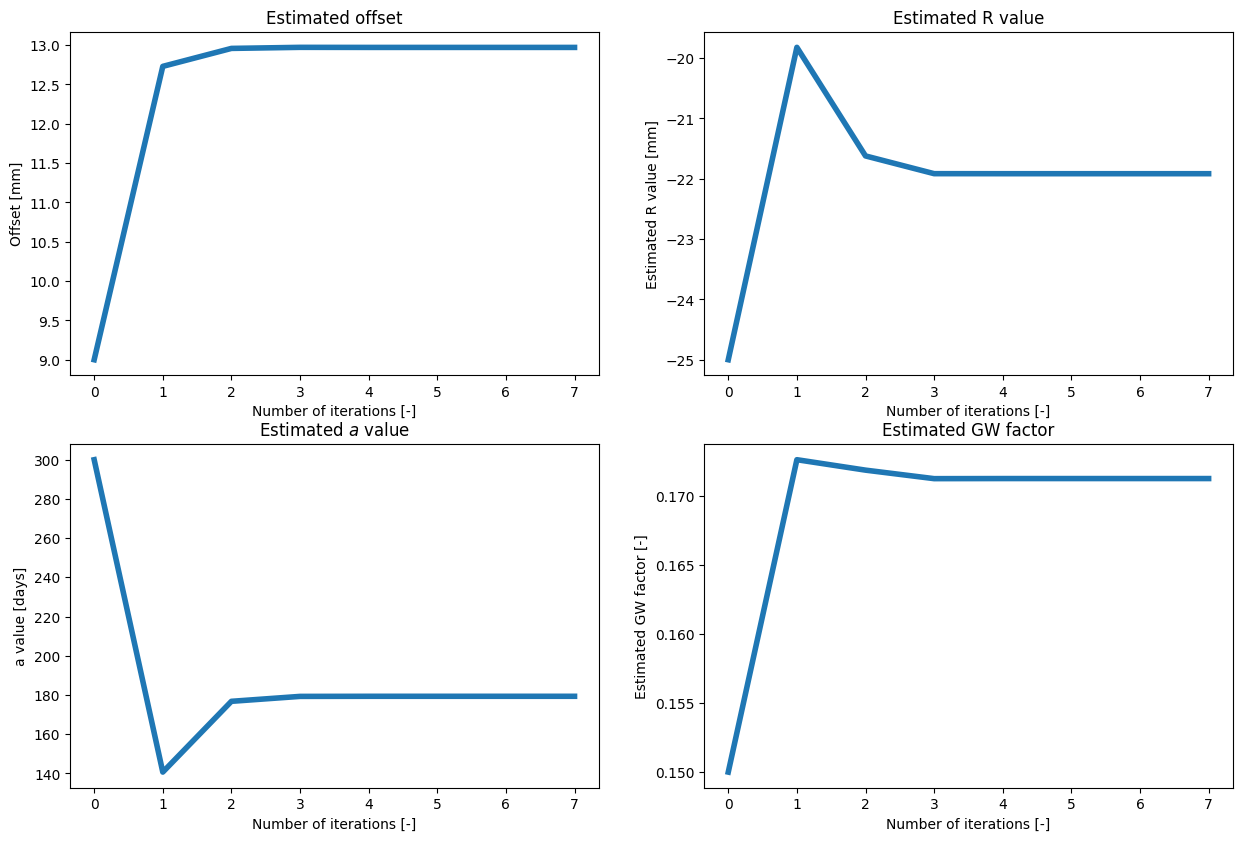

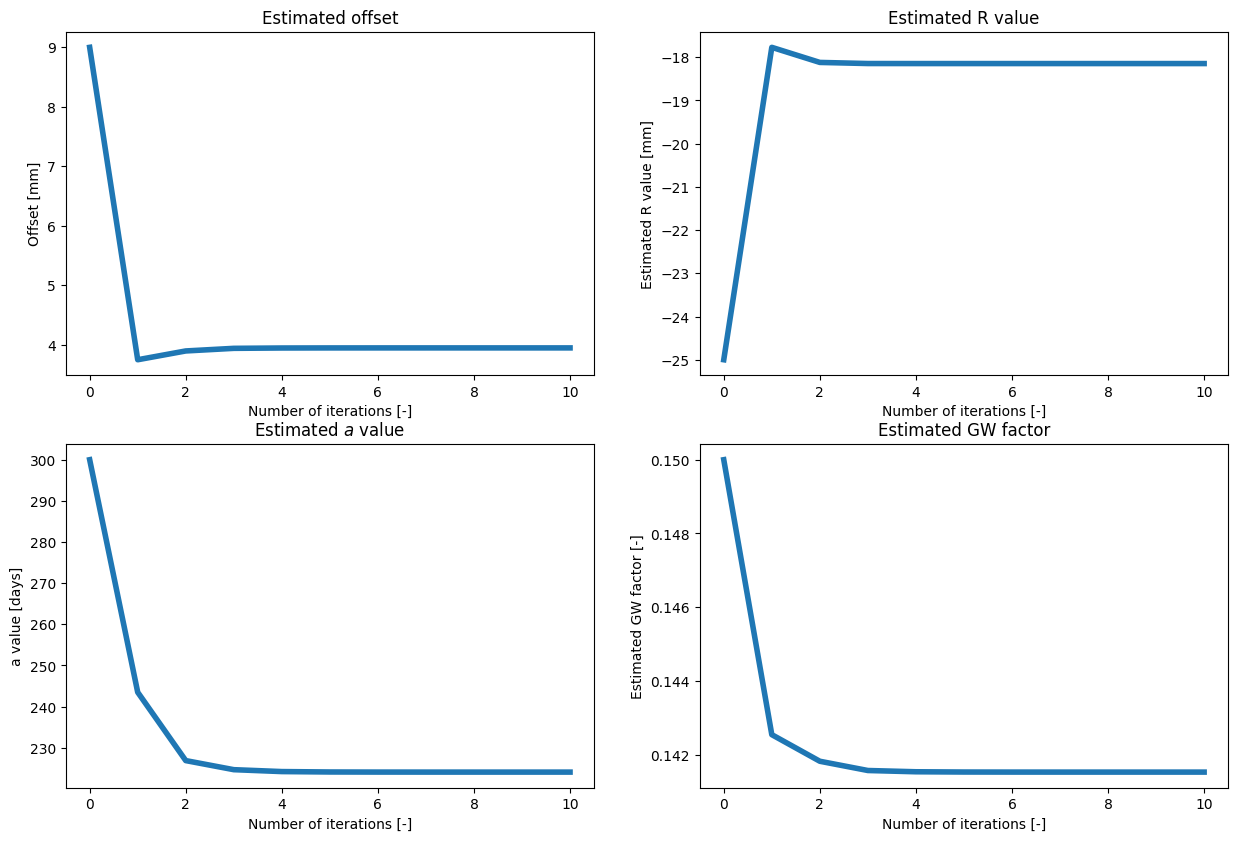

In [17]:
# def plot_fit_iteration(d):
#     """Plot value of each parameter, each iteration."""
#     plt.figure(figsize = (15,4))
#     plt.subplots_adjust(top = 2)
# 
#     plt.subplot(2,2,1)
#     YOUR_CODE_HERE
#     plt.title('YOUR_CODE_HERE')
#     plt.ylabel('YOUR_CODE_HERE [UNITS]')
#     plt.xlabel('Number of iterations [-]')
#   
#     plt.subplot(2,2,2)
#     YOUR_CODE_HERE
#     plt.title('YOUR_CODE_HERE')
#     plt.ylabel('YOUR_CODE_HERE [UNITS]')
#     plt.xlabel('Number of iterations [-]')
#     
#     plt.subplot(2,2,3)
#     YOUR_CODE_HERE
#     plt.title('YOUR_CODE_HERE')
#     plt.ylabel('YOUR_CODE_HERE [UNITS]')
#     plt.xlabel('Number of iterations [-]')
#     
#     plt.subplot(2,2,4)
#     YOUR_CODE_HERE
#     plt.title('YOUR_CODE_HERE')
#     plt.ylabel('YOUR_CODE_HERE [UNITS]')
#     plt.xlabel('Number of iterations [-]')
# 
# plot_fit_iteration(m1)
# plot_fit_iteration(m2)

# SOLUTION
def plot_fit_iteration(d):
    """Plot value of each parameter, each iteration."""
    plt.figure(figsize = (15,4))
    plt.subplots_adjust(top = 2)

    plt.subplot(2,2,1)
    plt.plot(d['x_hat_all_iterations'][:,0], linewidth=4)
    plt.title('Estimated offset')
    plt.ylabel('Offset [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,2)
    plt.plot(d['x_hat_all_iterations'][:,1], linewidth=4)
    plt.title('Estimated R value')
    plt.ylabel('Estimated R value [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,3)
    plt.plot(d['x_hat_all_iterations'][:,2], linewidth=4)
    plt.title('Estimated $a$ value')
    plt.ylabel('a value [days]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,4)
    plt.plot(d['x_hat_all_iterations'][:,3], linewidth=4)
    plt.title('Estimated GW factor')
    plt.ylabel('Estimated GW factor [-]')
    plt.xlabel('Number of iterations [-]')

plot_fit_iteration(m1)
plot_fit_iteration(m2)

## Part 3: Assessing Results

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1: Precision of Estimates</b>     
    
What is the quality of the final estimates? 

First complete the function for printing standard deviations of the estimate of each unknown parameter. Then run the cell to print the full covariance matrix of your estimates.

We can re-use the function <code>model_summary()</code> from Part 0 of this notebook to verify that you have correctly computed the standard deviations of the estimates.
</p>
</div>

In [19]:
# def show_std(Sigma_X_hat, data_type):
#     print ('The standard deviation for',
#            data_type + '-offset is',
#            YOUR_CODE_HERE, 'UNITS')
#     print ('The standard deviation for',
#            data_type + '-R is',
#            YOUR_CODE_HERE, 'UNITS')
#     print ('The standard deviation for',
#            data_type + '-a is',
#            YOUR_CODE_HERE, 'UNITS')
#     print ('The standard deviation for',
#            data_type + '-the ground water factor',
#            YOUR_CODE_HERE, 'UNITS')
    

# print ('Covariance matrix of estimated parameters (InSAR):')
# print (YOUR_CODE_HERE, '\n')
# show_std(YOUR_CODE_HERE)
# print()
# model_summary(YOUR_CODE_HERE)

# print ('Covariance matrix of estimated parameters (GNSS):')
# print (YOUR_CODE_HERE, '\n')
# show_std(YOUR_CODE_HERE)
# print()
# model_summary(YOUR_CODE_HERE)

# SOLUTION:
def show_std(Sigma_X_hat, data_type):
    print ('The standard deviation for',
           data_type + '-offset is',
           np.round(np.sqrt(Sigma_X_hat[0,0]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-R is',
           np.round(np.sqrt(Sigma_X_hat[1,1]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-a is',
           np.round(np.sqrt(Sigma_X_hat[2,2]),2), 'days')
    print ('The standard deviation for',
           data_type + '-the ground water factor',
           np.round(np.sqrt(Sigma_X_hat[3,3]),3), '[-]')
    

print ('Covariance matrix of estimated parameters (InSAR):')
print (m1['Sigma_X_hat'], '\n')
show_std(m1['Sigma_X_hat'], 'InSAR')
print()
model_summary(m1)

print ('Covariance matrix of estimated parameters (GNSS):')
print (m2['Sigma_X_hat'], '\n')
show_std(m2['Sigma_X_hat'], 'GNSS')
print()
model_summary(m2)

Covariance matrix of estimated parameters (InSAR):
[[ 4.771e+00 -5.522e-01 -7.605e+00  3.183e-02]
 [-5.522e-01  1.017e+00  4.726e+00  2.657e-03]
 [-7.605e+00  4.726e+00  4.461e+02  6.328e-02]
 [ 3.183e-02  2.657e-03  6.328e-02  2.771e-04]] 

The standard deviation for InSAR-offset is 2.18 mm
The standard deviation for InSAR-R is 1.01 mm
The standard deviation for InSAR-a is 21.12 days
The standard deviation for InSAR-the ground water factor 0.017 [-]

Summary of Model
----------------
  Data type: InSAR
  Model type: Non-Linear Least Squares
  Number of observations: 61
  Model parameters:
    X_hat_0 =   12.971  +/-  2.184  (c.o.v.  0.168)
    X_hat_1 =  -21.916  +/-  1.009  (c.o.v. -0.046)
    X_hat_2 =  179.353  +/- 21.120  (c.o.v.  0.118)
    X_hat_3 =    0.171  +/-  0.017  (c.o.v.  0.097)
----------------

Covariance matrix of estimated parameters (GNSS):
[[ 2.306e+01 -2.474e+00 -7.557e+01  1.514e-01]
 [-2.474e+00  4.674e+00  2.167e+00  6.718e-03]
 [-7.557e+01  2.167e+00  6.317e+0

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.2: Visualizing Results</b>   

Create a plot of the model predictions and residuals, along with a confidence interval for each plot. Include also the empirical and theoretical distribution of residuals.

The file <code>functions.py</code> includes the functions <code>get_CI()</code>, <code>plot_model()</code>, <code>plot_residual()</code> and <code>plot_residual_histogram()</code> from GA 1.3 last week.

Prior to using the functions you will need to compute the modeled displacements, $\hat{\mathrm{Y}}$ using a function defined previously in this notebook.

You can choose your own significance level for the confidence interval.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>
<b>Tip</b>

Open
<code>functions.py</code> and read the contents if you cannot recall how each function is used. You can also use the <code>help()</code> method in Python to print a docstring (try it in the cell below!).</p></div>

In [20]:
help(get_CI)

Help on function get_CI in module functions:

get_CI(d, alpha)
    Compute the confidence intervals.

    Uses dict as input/output:
      - inputs defined from existing values in dict
      - outputs defined as new values in dict



The mean value of the InSAR residuals is 0.0 mm
The standard deviation of the InSAR residuals is 1.852 mm


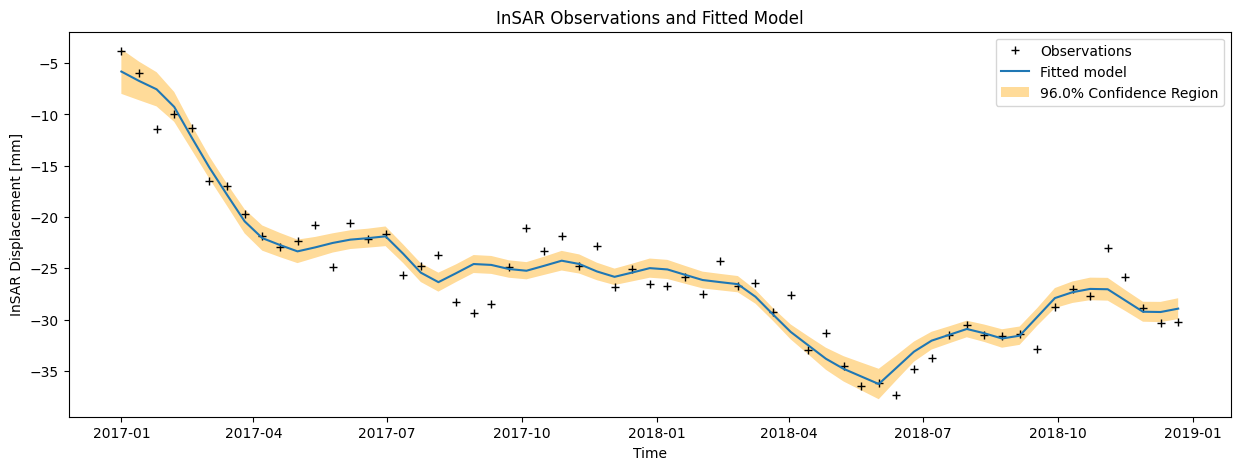

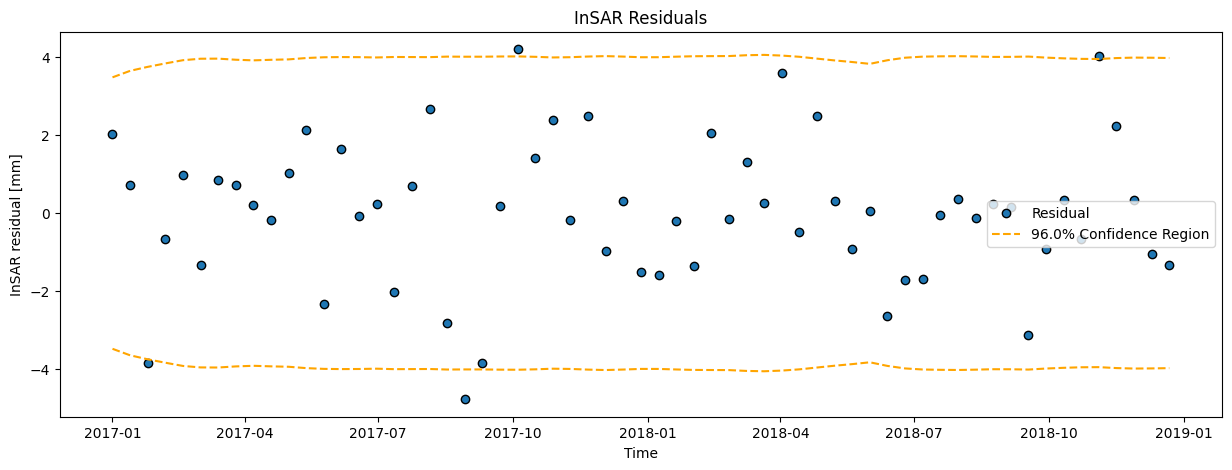

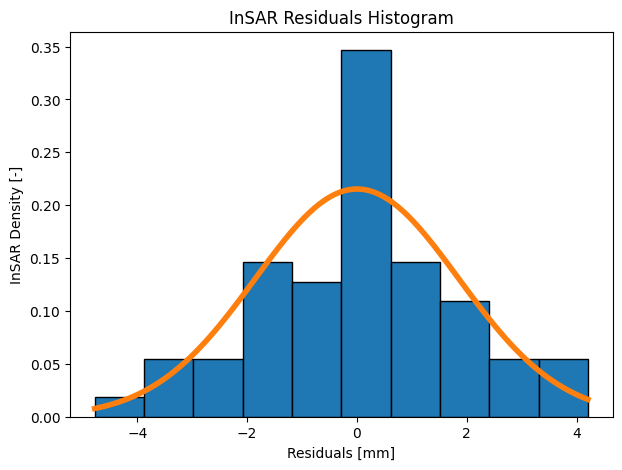

In [21]:
# m1['Y_hat'] = YOUR_CODE_HERE
# m1 = get_CI(YOUR_CODE_HERE)
# plot_model(YOUR_CODE_HERE)
# plot_residual(YOUR_CODE_HERE)
# plot_residual_histogram(YOUR_CODE_HERE);

# SOLUTION:
m1['Y_hat'] = functional_model(m1['X_hat'], m1)
m1 = get_CI(m1, 0.04)
plot_model(m1)
plot_residual(m1)
plot_residual_histogram(m1);

The mean value of the GNSS residuals is -0.0 mm
The standard deviation of the GNSS residuals is 15.315 mm


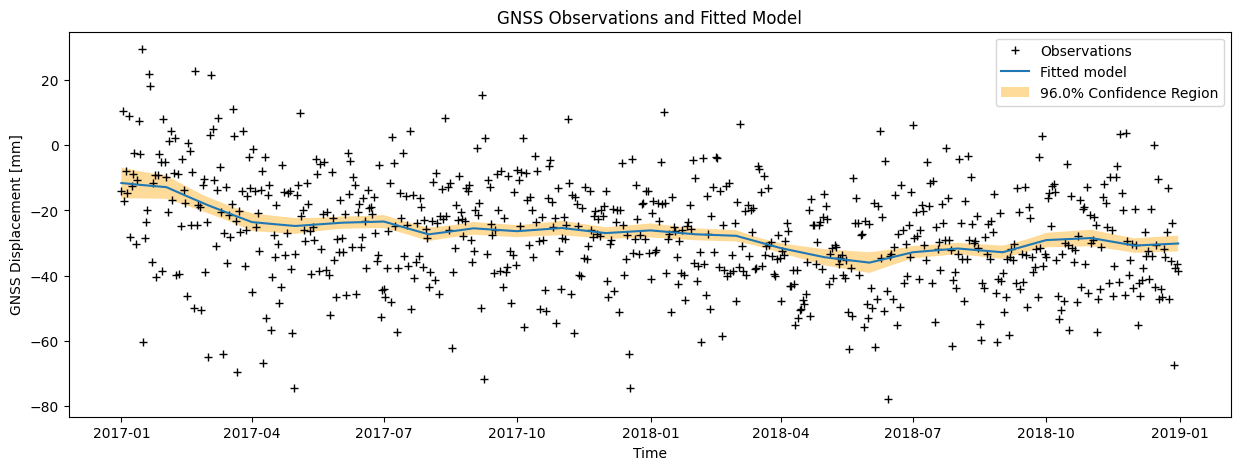

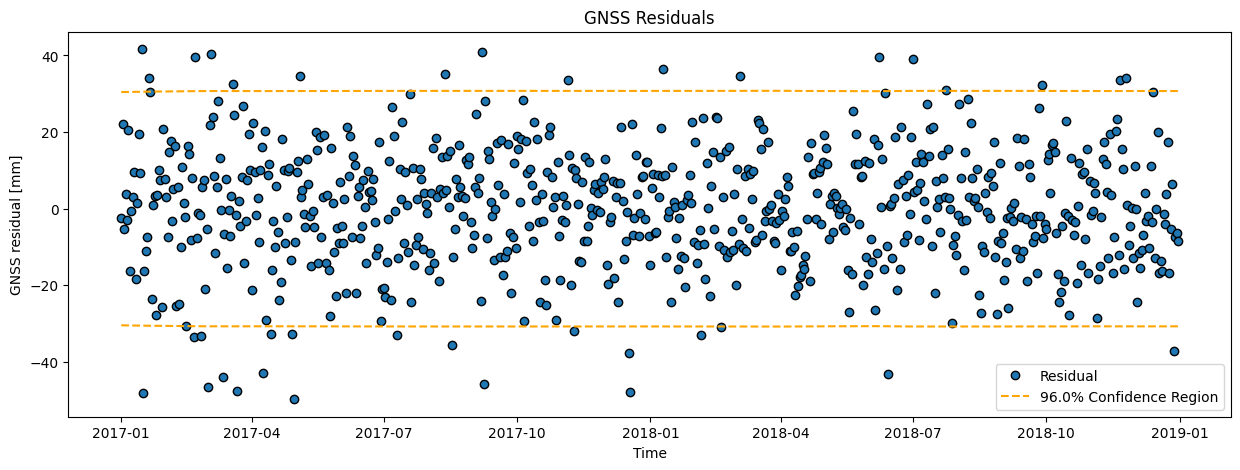

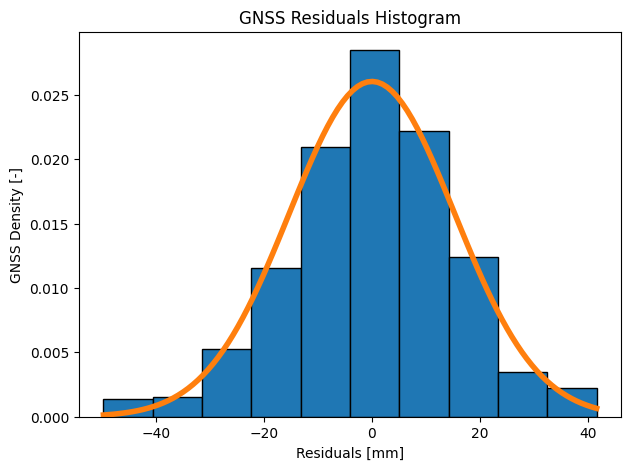

In [22]:
# m1['Y_hat'] = YOUR_CODE_HERE
# m1 = get_CI(YOUR_CODE_HERE)
# plot_model(YOUR_CODE_HERE)
# plot_residual(YOUR_CODE_HERE)
# plot_residual_histogram(YOUR_CODE_HERE);

# SOLUTION:
m2['Y_hat'] = functional_model(m2['X_hat'], m2)
m2 = get_CI(m2, 0.04)
plot_model(m2)
plot_residual(m2)
plot_residual_histogram(m2);

## Part 4: Hypothesis Test

In GA 1.3 and GA 1.4 we used two different models:
* GA 1.3: A linear model
* GA 1.4: A model with linear and power components

Now we are going to test which model fits the data better. We will do this with the Generalized Likelihood Ratio (GLR) test for both the GNSS and InSAR observations.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.1: </b>   

Identify the appropriate test statistic and compute the critical value with level of significance $\alpha=0.005$.
</p>
</div>


In [23]:
# YOUR_CODE_HERE (probably will be more than one line)
# print(f'The critical value is {np.round(k, 3)}')

# SOLUTION
q = 1
alpha = 0.005 
k = chi2.ppf(1 - alpha, df=q)
print(f'The critical value is {np.round(k, 3)}')

The critical value is 7.879


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2: </b>   

Compute the test statistic for InSAR data.
</p>
</div>


In [27]:
# YOUR_CODE_HERE (probably will be more than one line)
# print(f'The test statistic for InSAR data is {np.round(t_insar, 3)}')

# SOLUTION
t1_insar = (m1_blue['e_hat'].T
            @ np.linalg.inv(m1_blue['Sigma_Y'])
            @ m1_blue['e_hat'])
t2_insar = (m1['e_hat'].T
            @ np.linalg.inv(m1['Sigma_Y'])
            @ m1['e_hat'])
t_insar = t1_insar - t2_insar
print(f'The test statistic for InSAR data is {np.round(t_insar, 3)}')

The test statistic for InSAR data is 95.616


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.3: </b>   

Compute the test statistic for GNSS data.
</p>
</div>


In [28]:
# YOUR_CODE_HERE (probably will be more than one line)
# print(f'The test statistic for GNSS data is {np.round(t_gnss, 3)}')

# SOLUTION
t1_gnss = (m2_blue['e_hat'].T
           @np.linalg.inv(m2_blue['Sigma_Y'])
           @m2_blue['e_hat'])
t2_gnss = (m2['e_hat'].T
           @np.linalg.inv(m2['Sigma_Y'])
           @m2['e_hat'])
t_gnss = t1_gnss - t2_gnss
print(f'The test statistic for GNSS data is {np.round(t_gnss, 3)}')

The test statistic for GNSS data is 7.788


**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.